In [23]:
%pip install pandas numpy tensorflow scikit-learn


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split

MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
GLOVE_PATH = 'glove.42B.300d.txt'
CSV_PATH = 'sentiment.csv'



In [25]:
df = pd.read_csv(CSV_PATH)

df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0)

texts = df['review'].values
labels = df['sentiment'].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

word_index = tokenizer.word_index

In [ ]:
embeddings_index = {}

with open(GLOVE_PATH, encoding='utf-8') as f:
    for index, line in enumerate(f):
        values = line.split()
        word = values[0]
        embeddings_index[word] = np.asarray(values[1:], dtype='float32')

num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [28]:
model = Sequential([
    Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],trainable=False),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6831 - loss: 0.5617 - val_accuracy: 0.8298 - val_loss: 0.3847
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8022 - loss: 0.4065 - val_accuracy: 0.8580 - val_loss: 0.3272
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8305 - loss: 0.3505 - val_accuracy: 0.8578 - val_loss: 0.3150
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8491 - loss: 0.3098 - val_accuracy: 0.8625 - val_loss: 0.3117
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8686 - loss: 0.2691 - val_accuracy: 0.8621 - val_loss: 0.3296


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

    Negative       0.83      0.90      0.87      4961
    Positive       0.89      0.82      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



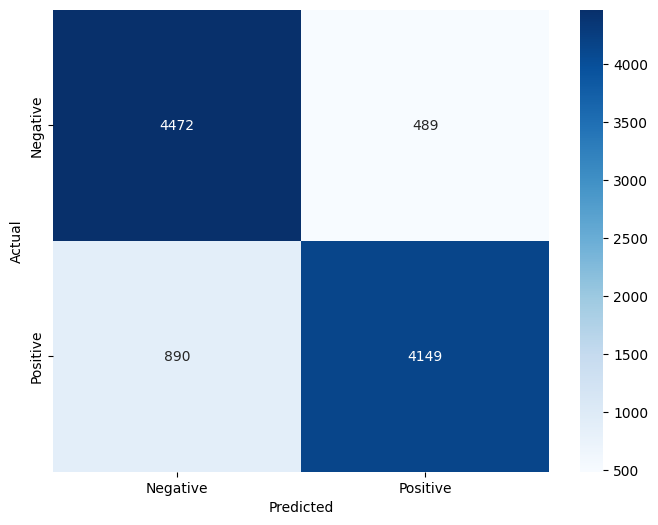

In [30]:
y_pred_probs = model.predict(X_test)

y_pred = (y_pred_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

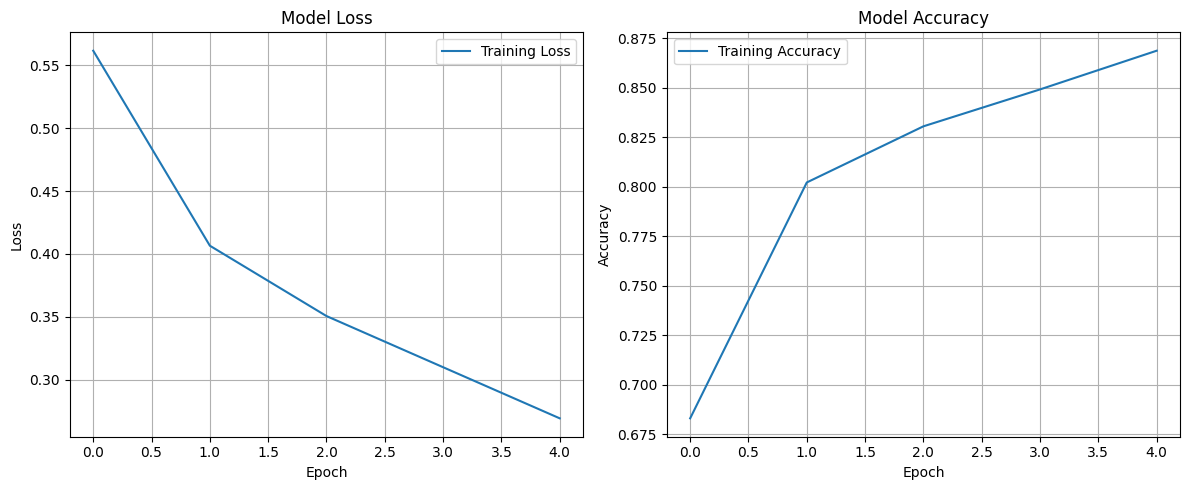

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
def predict_sentiment(text, model, tokenizer, max_length=100):
    sequence = tokenizer.texts_to_sequences([text])
    
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    probability = model.predict(padded_sequence)[0][0]
    
    if probability > 0.5:
        sentiment = "Positive"
        confidence = probability
    else:
        sentiment = "Negative"
        confidence = 1 - probability
        
    print(f"Review: \"{text}\"")
    print(f"Sentiment: {sentiment} ({confidence * 100:.2f}%)")

predict_sentiment("This movie was absolutely fantastic! The acting was great.", model, tokenizer)

predict_sentiment("I wasted two hours of my life.", model, tokenizer)

predict_sentiment("This movie made me feel extremely unconfortable. But I kinda like that.", model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Review: "This movie was absolutely fantastic! The acting was great."
Sentiment: Positive (99.80%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Review: "I wasted two hours of my life."
Sentiment: Negative (97.31%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Review: "This movie made me feel extremely unconfortable. But I kinda like that."
Sentiment: Negative (64.69%)
